### Sampling from Gaussian Processes

In [7]:
import numpy as np

# squared exponential kernel
def exponential_cov(x, y, params):
    return params[0] * np.exp( -0.5 * params[1] * np.subtract.outer(x, y)**2)


def conditional(x_new, x, y, params):
    B = exponential_cov(x_new, x, params)
    C = exponential_cov(x, x, params)
    A = exponential_cov(x_new, x_new, params)
    mu = np.linalg.inv(C).dot(B.T).T.dot(y)
    sigma = A - B.dot(np.linalg.inv(C).dot(B.T))
    return(mu.squeeze(), sigma.squeeze())

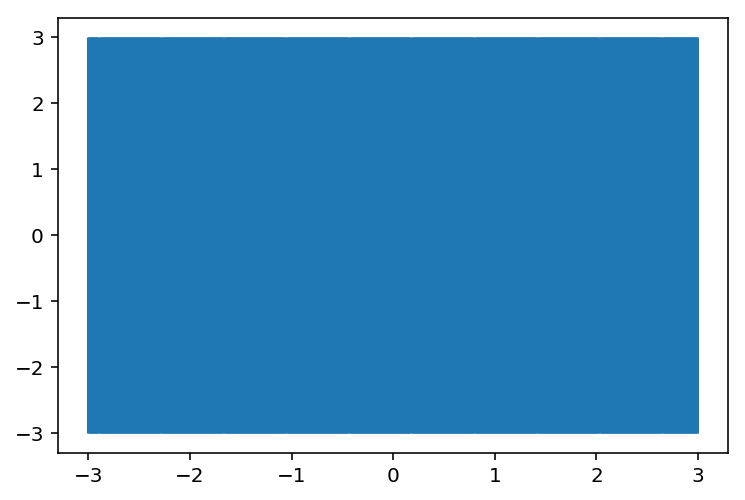

In [13]:
import matplotlib.pylab as plt
 
theta = [3, 10]
sigma_0 = exponential_cov(0, 0, theta)
xpts = np.arange(-3, 3, step=0.01)

plt.errorbar(x = xpts, y = np.zeros(len(xpts)), 
             yerr = sigma_0, capsize = 0);

In [15]:
x = [1.]
y = [np.random.normal(scale=sigma_0)]
y

[-0.5660148593118512]

We can now update our confidence band, given the point that we just sampled, using the covariance function to generate new point-wise intervals, conditional on the value $[x_0, y_0]$.

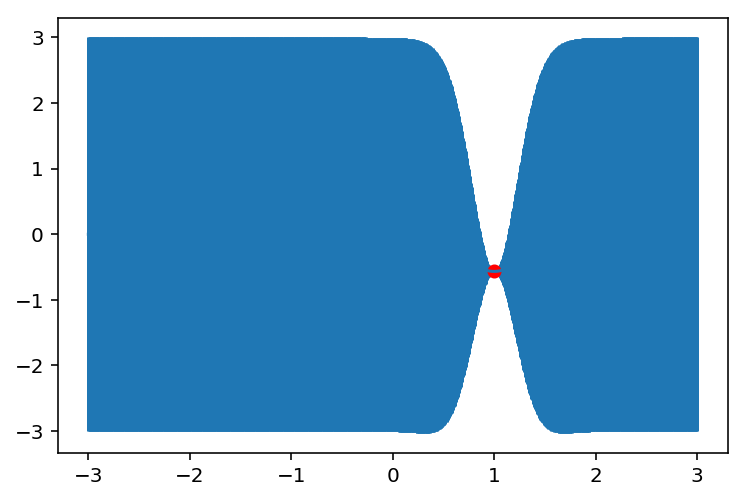

In [20]:
σ_1 = exponential_cov(x, x, theta)
 
def predict(x, data, kernel, params, sigma, t):
    k = [kernel(x, y, params) for y in data]
    Sinv = np.linalg.inv(sigma)
    y_pred = np.dot(k, Sinv).dot(t)
    sigma_new = kernel(x, x, params) - np.dot(k, Sinv).dot(k)
    return y_pred, sigma_new

x_pred = np.linspace(-3, 3, 1000)
predictions = [predict(i, x, exponential_cov, theta, σ_1, y) for i in x_pred]

y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro");